In [1]:
#INSTALLING DEPENDENCIES
!pip install torch==1.12.1
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━

In [2]:
#IMPORT LIBRARIES
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
#DATA LOADER:
horizontal_flip_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5)])
batch_size=10000
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=horizontal_flip_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=horizontal_flip_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#UNPICKLING FILES INTO DICTIONARIES:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
dict1 = unpickle(file='./data/cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='./data/cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='./data/cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='./data/cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='./data/cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='./data/cifar-10-batches-py/test_batch')

#LOADING TRAIN AND TEST DATA
train_x1 = torch.tensor(dict1[b'data'])
train_y1 = torch.tensor(dict1[b'labels'])
train_x2 = torch.tensor(dict2[b'data'])
train_y2 = torch.tensor(dict2[b'labels'])
train_x3 = torch.tensor(dict3[b'data'])
train_y3 = torch.tensor(dict3[b'labels'])
train_x4 = torch.tensor(dict4[b'data'])
train_y4 = torch.tensor(dict4[b'labels'])
train_x5 = torch.tensor(dict5[b'data'])
train_y5 = torch.tensor(dict5[b'labels'])
test_x = torch.tensor(dict_test[b'data'])
test_y = torch.tensor(dict_test[b'labels'])

train_x = torch.cat((train_x1, train_x2, train_x3, train_x4, train_x5), dim=0)
train_y = torch.cat((train_y1, train_y2, train_y3, train_y4, train_y5), dim=0)
train_x = torch.reshape(train_x, (50000, 3, 32, 32))/255
test_x = torch.reshape(test_x, (10000, 3, 32, 32))/255

train_y_framed = torch.nn.functional.one_hot(train_y.clone().detach(), num_classes=10)
train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
test_y_framed = torch.nn.functional.one_hot(test_y.clone().detach(), num_classes=10)
test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-3-923f3ca44ac2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
<ipython-input-3-923f3ca44ac2>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


In [4]:
#DEFINING MODEL:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con1 = torch.nn.Conv2d(3,32,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con2 = torch.nn.Conv2d(32,64,(5,5),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con3 = torch.nn.Conv2d(64,64,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.pool = torch.nn.MaxPool2d((2,2), stride=(2,2), padding=0)
        self.f1 = torch.nn.Linear(64*7*7, 64)
        self.f2 = torch.nn.Linear(64, 10)
        self.soft_max = torch.nn.LogSoftmax(dim=1)
        self.rel = torch.nn.functional.relu

    def forward(self, x):
        x = self.con1(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con2(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con3(x)
        x = self.rel(x)
        x = torch.reshape(x, (-1, 64*7*7))
        x = self.f1(x)
        x = self.rel(x)
        x = self.f2(x)
        predict = self.soft_max(x)
        return predict

#PARAMETERS:
epochs = 20
batch = 32
n_batches = 1562

In [11]:
#RUNNING THE MODEL ON TRAINING AND TESTING:
mymodel = Model().to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=0.002)
# LRS = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
val_loss = torch.empty(epochs)
train_loss = torch.empty(epochs)
valb = 32
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_t = np.zeros(epochs)
acc_v = np.zeros(epochs)
for epoch in range(epochs):
  rloss = 0
  acc = 0
  count = 0
  vloss = 0
  for b in range(n_batches):
  # for b in range(10):
    xbatch = train_x[(b)*batch:(b+1)*(batch)].to('cuda:0')
    ybatch = train_y_framed[(b)*batch:(b+1)*(batch)].to('cuda:0')
    predict = mymodel.forward(xbatch)
    loss = criterion(predict,ybatch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rloss+=loss.item()
  # LR1  = optimizer.param_groups[0]["lr"]
  # LRS.step()
  # LR2 = optimizer.param_groups[0]["lr"]
  # print(f'LR from {LR1} to {LR2}')
  predict_val = mymodel.forward(test_x[:1000].to('cuda:0'))
  loss2 = criterion(predict_val, test_y_framed[:1000].to('cuda:0')).item()
  print(f"Training Loss after epoch {epoch+1}: {rloss}")
  train_loss[epoch] = rloss
  val_loss[epoch] = loss2
  predict_val_v = mymodel.forward(test_x[:1000].to('cuda:0'))
  predict_val_t = mymodel.forward(train_x[:1000].to('cuda:0'))
  pred_labels_v = torch.argmax(predict_val_v, dim=1)
  pred_labels_t = torch.argmax(predict_val_t, dim=1)
  acc_t[epoch]= metric(pred_labels_t, train_y[:1000].to('cuda:0'))
  acc_v[epoch]=metric(pred_labels_v, test_y[:1000].to('cuda:0'))
  print(f'TRAIN_ACC: {acc_t[epoch]}')
  print(f'VAL ACC: {acc_v[epoch]}')
  ## Validation loss 
  print(f"Validation Loss after epoch {epoch+1}: {loss2}")
  # p1 = torch.argmax(predic,dim=1)
  # p2 = torch.argmax(test_y_framed[:500], dim=1)
  # count = torch.sum(p2)
  # val_accs[epoch] = torch.sum(torch.where(p1==p2,1,0))/count
  # print(f'Validation acc after epoch {epoch+1}: {val_accs[epoch]}')
print(acc_t)
print(acc_v)



Training Loss after epoch 1: 2326.2269135713577
TRAIN_ACC: 0.5600000023841858
VAL ACC: 0.5799999833106995
Validation Loss after epoch 1: 1.2117574214935303
Training Loss after epoch 2: 1761.2809605300426
TRAIN_ACC: 0.6299999952316284
VAL ACC: 0.6320000290870667
Validation Loss after epoch 2: 1.0193126201629639
Training Loss after epoch 3: 1542.1653329133987
TRAIN_ACC: 0.6449999809265137
VAL ACC: 0.6650000214576721
Validation Loss after epoch 3: 0.983414351940155
Training Loss after epoch 4: 1392.8769391179085
TRAIN_ACC: 0.6869999766349792
VAL ACC: 0.6669999957084656
Validation Loss after epoch 4: 0.9669000506401062
Training Loss after epoch 5: 1289.9832101166248
TRAIN_ACC: 0.6909999847412109
VAL ACC: 0.6430000066757202
Validation Loss after epoch 5: 1.018181324005127
Training Loss after epoch 6: 1206.9883042871952
TRAIN_ACC: 0.7269999980926514
VAL ACC: 0.652999997138977
Validation Loss after epoch 6: 1.0326330661773682
Training Loss after epoch 7: 1145.1501298099756
TRAIN_ACC: 0.714999

In [12]:
#CALCULATING FINAL VALIDATION ACCURACY AND CLASSWISE ACCURACIES:
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_metric = MulticlassAccuracy(num_classes=10, average=None).to('cuda:0')
# finalpred = mymodel.forward(test_x[:1000])
pred_labels = torch.argmax(predict_val_v, dim=1)
classaccs = acc_metric(pred_labels, test_y[:1000].to('cuda:0'))
accfinal = metric(pred_labels, test_y[:1000].to('cuda:0'))
print(accfinal)
print(classaccs)
# class_acc[0]=classaccs

tensor(0.6240, device='cuda:0')
tensor([0.5631, 0.8764, 0.6100, 0.4272, 0.4333, 0.3953, 0.8125, 0.6765, 0.7075,
        0.6881], device='cuda:0')


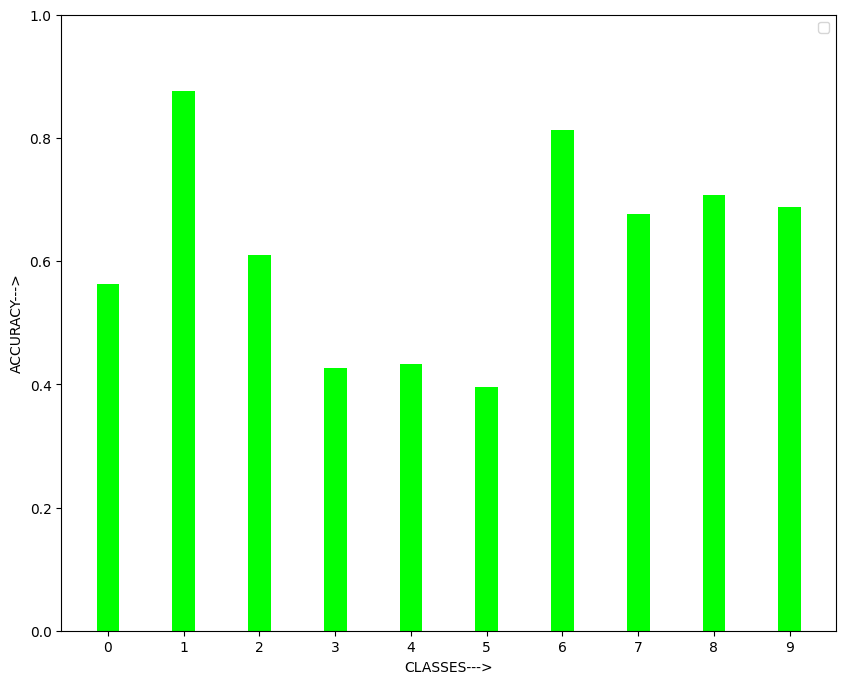

In [13]:
#CLASSWISE ACCURACY BAR-GRAPH
plt.figure(figsize=(10,8))
plt.xlabel('CLASSES--->')
plt.ylabel('ACCURACY--->')
plt.xticks(np.arange(0,10))
plt.ylim(0,1)
plt.bar(np.arange(0,10),classaccs.to('cpu'),color='lime',width=0.3)
plt.legend()
plt.show()

In [14]:
#PRINTING THE LOSSES:
print(train_loss)
print(val_loss)
train_loss = train_loss/499.84
val_loss = val_loss/10
print(train_loss)
print(val_loss)
tloss = train_loss.detach().numpy()
vloss = val_loss.detach().numpy()

tensor([2326.2268, 1761.2810, 1542.1653, 1392.8770, 1289.9832, 1206.9883,
        1145.1501, 1081.2102, 1038.5107,  996.1364,  934.0717,  898.1343,
         840.3846,  822.4518,  774.3974,  748.2316,  740.5802,  699.2623,
         688.7854,  657.1022])
tensor([1.2118, 1.0193, 0.9834, 0.9669, 1.0182, 1.0326, 1.1452, 1.3570, 1.3824,
        1.4399, 1.6510, 1.8126, 1.7256, 1.6810, 1.8083, 1.8375, 1.7371, 1.8426,
        1.9170, 1.8793])
tensor([4.6539, 3.5237, 3.0853, 2.7866, 2.5808, 2.4147, 2.2910, 2.1631, 2.0777,
        1.9929, 1.8687, 1.7968, 1.6813, 1.6454, 1.5493, 1.4969, 1.4816, 1.3990,
        1.3780, 1.3146])
tensor([0.1212, 0.1019, 0.0983, 0.0967, 0.1018, 0.1033, 0.1145, 0.1357, 0.1382,
        0.1440, 0.1651, 0.1813, 0.1726, 0.1681, 0.1808, 0.1838, 0.1737, 0.1843,
        0.1917, 0.1879])


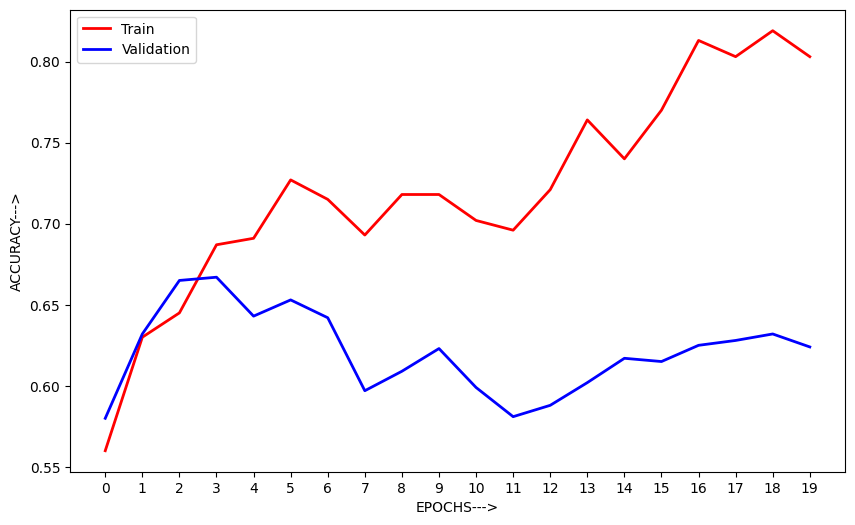

In [15]:
#CODE TO PLOT VALIDATION ACCURACY:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, acc_t, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, acc_v, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

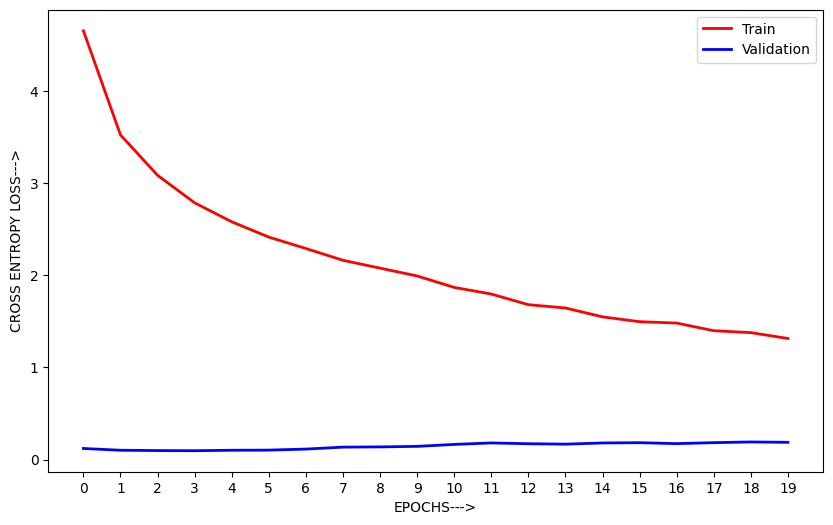

In [16]:
#CODE TO PLOT TRAINING AND VALIDATION LOSSES:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,20)
epoch_ticks = np.arange(0,22)
plt.xticks(epoch_ticks)
# plt.ylim(90,93)
plt.plot(epoch_arr, train_loss, 'r', label='Train', linewidth=2)
plt.plot(epoch_arr, val_loss, 'b', label='Validation', linewidth=2)
plt.legend()
plt.show()

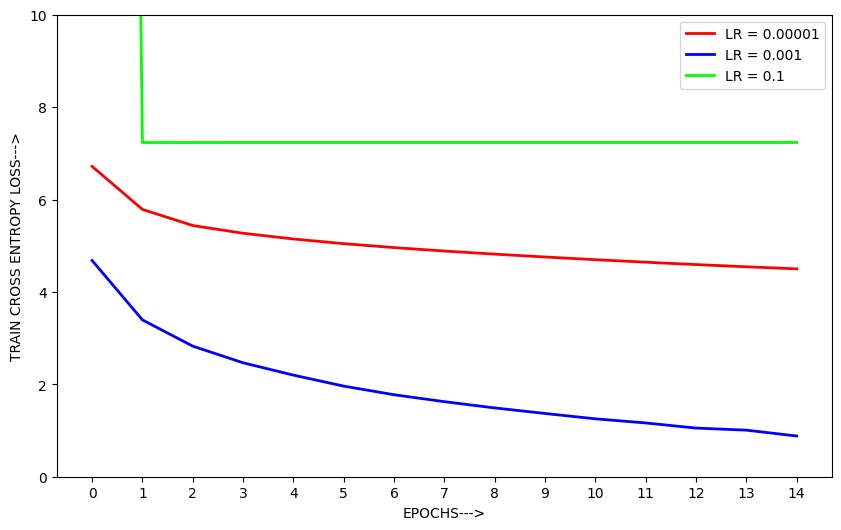

In [17]:
#COMPARING LEARNING RATES:
train_loss_00001 = np.array([6.7169, 5.7859, 5.4376, 5.2699, 5.1458, 5.0447, 4.9595, 4.8850, 4.8180,
        4.7559, 4.6978, 4.6434, 4.5919, 4.5438, 4.4993])
train_loss_001 = np.array([4.6798, 3.3941, 2.8265, 2.4660, 2.1989, 1.9609, 1.7747, 1.6242, 1.4892,
        1.3689, 1.2531, 1.1638, 1.0528, 1.0081, 0.8814, 0.8194, 0.7478, 0.7082,
        0.6791, 0.6537, 0.6183, 0.5833, 0.5416, 0.5054, 0.5074, 0.4823, 0.4684,
        0.4659, 0.4149, 0.4265, 0.4078, 0.3694, 0.3801, 0.3687, 0.3771, 0.3576,
        0.3460, 0.3161, 0.3150, 0.3330])
train_loss_01 = np.array([92.3200,  7.2332,  7.2339,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,
         7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,  7.2340,
         7.2340,  7.2340,  7.2340,  7.2340])
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('TRAIN CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,15)
epoch_ticks = np.arange(0,15)
plt.xticks(epoch_ticks)
plt.ylim(0,10)
plt.plot(epoch_arr, train_loss_00001[:15], 'r', label='LR = 0.00001', linewidth=2)
plt.plot(epoch_arr, train_loss_001[:15], 'b', label='LR = 0.001', linewidth=2)
plt.plot(epoch_arr, train_loss_01[:15], 'lime', label='LR = 0.1', linewidth=2)
plt.legend()
plt.show()